In [ ]:
!nvidia-smi

Wed Nov 22 03:59:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import re
import pickle
import tensorflow as tf

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from glob import glob

In [ ]:
def cargar_datos(path='./'):
    """
    Loads multiple datasets from CSV files located in a specific path.
    :param path: Path where the CSV files are located.
    :return: List of DataFrames loaded from the CSV files.
    """
    datasets = glob("dataset-preproc-*csv")
    ns = [int(d.split(".")[0].split("-")[-1]) for d in datasets]
    ns.sort()
    dataframes = []
    contador = 0
    print("[INFO]: Loading datasets")
    print("(index: dataset name)\n")
    for i in ns[:]:
        fname = f'dataset-preproc-{i}.csv'
        print(f"{contador}: " + fname)
        try:
            dataframe = pd.read_csv(fname, index_col='datetime')
            contador+=1
        except:
            dataframe = pd.read_csv(fname, index_col='datetime', sep=';')
            contador+=1

        dataframe.index = pd.to_datetime(dataframe.index)
        dataframes.append(dataframe)
    return dataframes

def preprocesar_datos(input_data, in_length, date_hour, out_lengths):
    """
    Preprocesses data for modeling, based on the input length and a specific date/time.
    :param input_data: DataFrame with the input data.
    :param in_length: Length of the input (number of time steps).
    :param date_hour: Specific date and time to start the prediction.
    :return: A dictionary with preprocessed data for modeling.
    """
    output_data = {}
    try:
        fh = pd.to_datetime(date_hour, infer_datetime_format=True)
    except ValueError:
        print('Error en el formato de fecha/hora.')
        return {}

    start = datetime(fh.year, fh.month, fh.day, fh.hour, fh.minute, fh.second)
    end = start + timedelta(hours=in_length - 1)

    dates = []
    for i in range(len(out_lengths)):
        dates.append(start + timedelta(hours=i))
    dates_v = pd.to_datetime(dates)

    df_lag = input_data.loc[:start].iloc[-in_length:]

    if df_lag.shape[0] != in_length:
        raise Exception('Error en las fechas de inicio y/o finalización.')
    output_data['model_input'] = df_lag
    start_obs = start + timedelta(hours=in_length)
    end_obs = start_obs + timedelta(hours=in_length - 1)
    output_data['caudal_obs'] = pd.Series([np.nan for i in range(len(out_lengths))],
                                          index=dates_v)
    return output_data

def cargar_modelos(ruta, in_length):
    """
    Loads pre-trained models from a specific path.
    :param path: Path where the models are stored.
    :param in_length: Input length for the models.
    :return: Dictionary of loaded models.
    """
    def root_mean_squared_error(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred - y_true)))

    modelos = {}
    listado = os.listdir(os.path.join(path, 'modelos'))
    for item in listado:
        if (f'modelo_{in_length}' in item) and (item.endswith('h5')):
            modelo = tf.keras.models.load_model(os.path.join(path, 'modelos', item), compile=False)
            modelo.compile(optimizer='adam', loss=root_mean_squared_error)
            key = re.search('modelo_(.*)_U', item).group(1)
            modelos[key] = modelo

    return modelos

def predecir(in_data, modelos, scaler, in_length, out_lengths):
    """
    Performs predictions using pre-trained models and input data.
    :param in_data: Preprocessed input data.
    :param models: Dictionary of pre-trained models.
    :param scaler: Scaler object used for data scaling.
    :param in_length: Input length for the models.
    :param out_lengths: List of output lengths for the predictions.
    :return: Dictionary with predictions for each output length.
    """
    mn = scaler.data_min_[-1]
    mx = scaler.data_max_[-1]

    x = in_data['model_input'].values
    x_s = scaler.transform(x).reshape(1, x.shape[0], x.shape[1])

    predicciones = {f'{in_length}x{str(key)}': None for key in out_lengths}
    for output_length in out_lengths:
        key = f'{in_length}x{output_length}'
        y_pred_s = models[key].predict(x_s, verbose=0)
        y_pred = (mx - mn) * y_pred_s + mn

        flatten_y_pred = y_pred.flatten()
        in_data_splitted = in_data['caudal_obs'].index[:output_length]
        predicciones[key] = pd.Series(data=flatten_y_pred,
                                      index=in_data_splitted
                                      )

    return predicciones

def graficar_predicciones(caudal_in, caudal_obs, caudal_pred, in_length, out_lengths):
    """
    Plots predictions by comparing them with actual flow data.
    :param caudal_in: Input flow series (observed).
    :param caudal_obs: Series of observed flow.
    :param caudal_pred: Dictionary of predicted flow series for each output length.
    :param in_length: Input length of the models.
    :param out_lengths: List of output lengths used in the predictions.
    """
    num_graficas = len(out_lengths)
    fig, ax = plt.subplots(nrows=num_graficas, figsize=(25, 40))
    ax = ax.flatten()
    fig.subplots_adjust(hspace=1.5)

    for i, out_length in enumerate(out_lengths):
        key = f'{in_length}x{out_length}'
        serie_ref = pd.concat([caudal_in, caudal_obs[:out_length]])
        serie_pred = caudal_pred[key]

        ax[i].plot(serie_ref.index, serie_ref.values, color='#1e81b0', label='Caudal observado')
        ax[i].plot(serie_pred.index, serie_pred.values, color='#e28743', label='Caudal predicho')
        ax[i].axvline(x=serie_pred.index[0], color='r', ls='--', lw=2)

        ax[i].set_xlabel('Fecha/hora', size=14)
        ax[i].set_ylabel('Caudal ($m^3/s$)', size=14)
        ax[i].set_xlim((serie_ref.index[0], serie_pred.index[-1]))
        ax[i].grid()
        ax[i].set_title(f'Predicciones con modelo {key}', fontsize=16)
        ax[i].legend()
        ax[i].set_xticks(ax[i].get_xticks(), ax[i].get_xticklabels(), rotation=45, ha='right')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
        ax[i].xaxis.set_major_locator(mdates.HourLocator(interval=2))

    plt.show()

def graficar_conos(caudal_in, caudal_obs, caudal_pred, in_length, out_lengths):
    """
    Plots uncertainty cones around the flow predictions.
    :param caudal_in: Input flow series (observed).
    :param caudal_obs: Series of observed flow.
    :param caudal_pred: Dictionary of predicted flow series for each output length.
    :param in_length: Input length of the models.
    :param out_lengths: List of output lengths used in the predictions.
    """
    df_preds = pd.DataFrame({k: pd.Series(v) for k, v in caudal_pred.items()})
    df_preds_min = df_preds.min(axis=1)
    df_preds_max = df_preds.max(axis=1)
    df_preds_mean = df_preds.mean(axis=1)

    num_graficas = len(out_lengths)
    fig, ax = plt.subplots(nrows=num_graficas, figsize=(25, 40))
    ax = ax.flatten()
    fig.subplots_adjust(hspace=0.5)

    for i, out_length in enumerate(out_lengths):
        key = f'{in_length}x{out_length}'
        serie_ref = pd.concat([caudal_in, caudal_obs])
        serie_ref[in_length + 1:] = np.nan
        serie_min = pd.concat([np.nan * caudal_in, df_preds_min[:out_length]])
        serie_max = pd.concat([np.nan * caudal_in, df_preds_max[:out_length]])
        serie_mean = pd.concat([np.nan * caudal_in, df_preds_mean[:out_length]])

        ax[i].plot(serie_ref.index, serie_ref.values, color='blue', label='Caudal observado')
        ax[i].plot(serie_mean.index, serie_mean.values, color='orange', ls='-', lw=2, label='Caudal predicho')
        ax[i].axvline(x=serie_ref.index[in_length], color='r', ls='--', lw=2)
        ax[i].fill_between(serie_min.index, serie_min.values, serie_max.values, color='#3dde71', alpha=0.5, label='Intervalo de confianza')

        ax[i].set_xlabel('', size=10)
        ax[i].set_ylabel('Caudal ($m^3/s$)', size=8)
        ax[i].set_xlim((serie_ref.index[0], serie_ref.index[-1]))
        ax[i].grid()
        ax[i].set_title(f'{key}', fontsize=16)
        ax[i].legend()
        ax[i].set_xticks(ax[i].get_xticks(), ax[i].get_xticklabels(), rotation=45, ha='right')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%d %H"))
        ax[i].xaxis.set_major_locator(mdates.HourLocator(interval=2))

    plt.show()

def graficar_conoss(caudal_in, caudal_obs, caudal_pred, in_length, out_lengths):
    """
    Plots uncertainty cones around the flow predictions.
    :param caudal_in: Input flow series (observed).
    :param caudal_obs: Series of observed flow.
    :param caudal_pred: Dictionary of predicted flow series for each output length.
    :param in_length: Input length of the models.
    :param out_lengths: List of output lengths used in the predictions.
    """
    df_preds = pd.DataFrame({k: pd.Series(v) for k, v in caudal_pred.items()})
    df_preds_min = df_preds.min(axis=1)
    df_preds_max = df_preds.max(axis=1)
    df_preds_mean = df_preds.mean(axis=1)

    data_dict = {}

    for i, out_length in enumerate(out_lengths):
        key = f'{in_length}x{out_length}'
        serie_ref = pd.concat([caudal_in, caudal_obs])
        serie_ref[in_length + 1:] = np.nan
        serie_min = pd.concat([np.nan * caudal_in, df_preds_min[:out_length]])
        serie_max = pd.concat([np.nan * caudal_in, df_preds_max[:out_length]])
        serie_mean = pd.concat([np.nan * caudal_in, df_preds_mean[:out_length]])

        plt.figure(figsize=(25, 5))
        plt.plot(serie_ref.index, serie_ref.values, color='blue', label='Caudal observado')
        plt.plot(serie_mean.index, serie_mean.values, color='orange', ls='-', lw=2, label='Caudal predicho')
        plt.axvline(x=serie_ref.index[in_length], color='r', ls='--', lw=2)
        plt.fill_between(serie_min.index, serie_min.values, serie_max.values, color='#3dde71', alpha=0.5, label='Intervalo de confianza')

        plt.xlabel('', size=10)
        plt.ylabel('Caudal ($m^3/s$)', size=8)
        plt.xlim((serie_ref.index[0], serie_ref.index[-1]))
        plt.grid()
        plt.title(f'{key}', fontsize=16)
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %H"))
        plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
        plt.show()
        print()

        # Store x-axis and y-axis data for each plot
        data_dict[i] = [serie_ref.index.tolist(), serie_ref.values.tolist(), serie_mean.values.tolist(), serie_min.values.tolist(), serie_max.values.tolist()]

    return data_dict

def calcular_indices_desempeno(preds_tr_vl_ts, tr_vl_ts_s, scaler, in_length, out_lengths):
    """
    Calculates performance indices (such as NSE) for predictions in training, validation, and test sets.
    :param preds_tr_vl_ts: Predictions in training, validation, and test sets.
    :param tr_vl_ts_s: Scaled training, validation, and test sets.
    :param scaler: Scaler used for the data.
    :param in_length: Input length of the models.
    :param out_lengths: List of output lengths used in the predictions.
    :return: Lists of NSE indices for training, validation, and test.
    """
    def nse(y_true, y_pred):
        return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

    mn = scaler.data_min_[-1]
    mx = scaler.data_max_[-1]

    nse_train_list, nse_val_list, nse_test_list = [], [], []
    for out_length in out_lengths:
        # Cálculos para cada conjunto de datos
        for subset, nse_list in zip(['train', 'val', 'test'], [nse_train_list, nse_val_list, nse_test_list]):
            y_true_s = tr_vl_ts_s[str(out_length)][subset]['y'].flatten()
            y_pred = preds_tr_vl_ts[str(out_length)][subset].flatten()
            y_true = (mx - mn) * y_true_s + mn

            nse_value = nse(y_true, y_pred)
            nse_list.append(nse_value)

    return nse_train_list, nse_val_list, nse_test_list

def graficar_indice_nse(nse_train, nse_val, nse_test, out_lengths):
    """
    Plots the NSE index for each output length in the training, validation, and test sets.
    :param nse_train: List of NSE indices for the training set.
    :param nse_val: List of NSE indices for the validation set.
    :param nse_test: List of NSE indices for the test set.
    :param out_lengths: List of output lengths used in the predictions.
    """
    titles = ['Train', 'Val', 'Test']
    indices = [nse_train, nse_val, nse_test]

    fig, ax = plt.subplots(3, figsize=(8, 15))
    fig.subplots_adjust(hspace=0.25)

    for i in range(3):
        ax[i].plot(out_lengths, indices[i], color='#1e81b0', ls='-', marker='o')
        ax[i].set_xlabel('Pronóstico (horas)', size=12)
        ax[i].set_xticks(out_lengths)
        ax[i].set_ylim((None, 1))
        ax[i].set_ylabel('$NSE$', size=14)
        ax[i].title.set_text(titles[i])
        ax[i].grid()

    plt.show()

In [ ]:
# PASO 1: Iniciar con el preprocesamiento de los datos
NFEATS = 33  # Número de covariables
LAG = 24  # Número de registros históricos para generar la predicción
RUTA = ""  # Define la ruta apropiada

In [ ]:
# Cargar modelos
modelos = cargar_modelos(RUTA, LAG)
modelos

{'24x1': <keras.src.engine.sequential.Sequential at 0x79aef5d4f700>,
 '24x2': <keras.src.engine.sequential.Sequential at 0x79aeec1a8160>,
 '24x3': <keras.src.engine.sequential.Sequential at 0x79aeec1a92d0>,
 '24x4': <keras.src.engine.sequential.Sequential at 0x79aee049f400>,
 '24x5': <keras.src.engine.sequential.Sequential at 0x79aee049f2e0>,
 '24x6': <keras.src.engine.sequential.Sequential at 0x79aee039f6a0>,
 '24x7': <keras.src.engine.sequential.Sequential at 0x79aee044d3c0>,
 '24x8': <keras.src.engine.sequential.Sequential at 0x79aee044c370>,
 '24x9': <keras.src.engine.sequential.Sequential at 0x79aee04221a0>,
 '24x10': <keras.src.engine.sequential.Sequential at 0x79aee02c2f80>,
 '24x11': <keras.src.engine.sequential.Sequential at 0x79aee01c2cb0>,
 '24x12': <keras.src.engine.sequential.Sequential at 0x79aee01e8700>,
 '24x13': <keras.src.engine.sequential.Sequential at 0x79aee01ebf10>,
 '24x14': <keras.src.engine.sequential.Sequential at 0x79aee01c3e50>}

In [ ]:
# Cargar el Scaler
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Ahora podemos usar 'scaler' como sobjeto scaler original
print("Scaler cargado:")
scaler

Scaler cargado:


MinMaxScaler()

In [ ]:
# Cargar datos utilizando la nueva función
dataframes = cargar_datos(RUTA)

# # out_lengths
out_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

[INFO]: Cargando datasets
(indice: nombre del dataset)

0: dataset-preproc-1.csv
1: dataset-preproc-2.csv
2: dataset-preproc-3.csv
3: dataset-preproc-4.csv
4: dataset-preproc-5.csv
5: dataset-preproc-6.csv
6: dataset-preproc-7.csv
7: dataset-preproc-8.csv
8: dataset-preproc-9.csv
9: dataset-preproc-10.csv


In [ ]:
# PASO 2: Generar una predicción sobre un dato
# Seleccionar un dataframe de los datos iniciales para el input
datos_in = dataframes[3]
print(f"{datos_in.shape = }")
# print(f"{datos_in.index = }\n")

# Definir fecha/hora para las predicciones
# fecha_hora = '2017-03-07 17:00:00'  # La fecha debe estar en formato AAAA-MM-DD HH:MM:SS
fecha_hora = datos_in.index[-1] ### -1 => ultima hora
indice_fh = datos_in.index.tolist().index(fecha_hora)

print(f"indice: {indice_fh} | hora: {fecha_hora}")
datos_in.shape

datos_in.shape = (5088, 33)
indice: 5087 | hora: 2018-05-31 23:00:00


(5088, 33)

In [ ]:
# Preprocesar los datos
resultado_preprocesado = preprocesar_datos(datos_in, LAG, fecha_hora, out_lengths)

# print(f"\n{resultado_preprocesado.keys() = }")

In [ ]:
resultado_preprocesado['model_input'].index[-1]

Timestamp('2018-05-31 23:00:00')

In [ ]:
# Realizar predicciones sobre el dataset pre-procesado
predicciones = predecir(resultado_preprocesado, modelos, scaler, LAG, out_lengths)

In [ ]:
# Extraer datos del predictor
caudal_in = resultado_preprocesado['model_input']['Caudal']  # Asumiendo que 'model_input' es un DataFrame
caudal_obs = resultado_preprocesado['caudal_obs']
caudal_pred = predicciones  # Obtenido de la función predecir

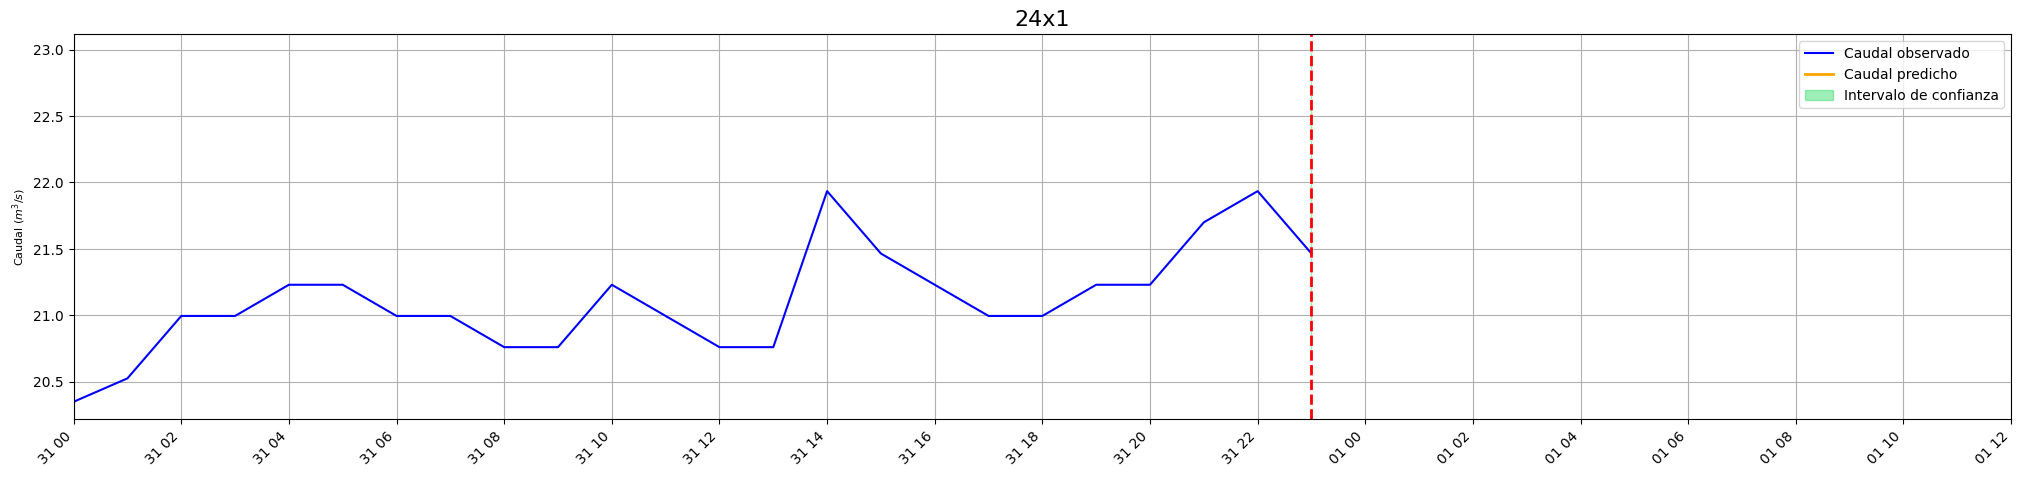

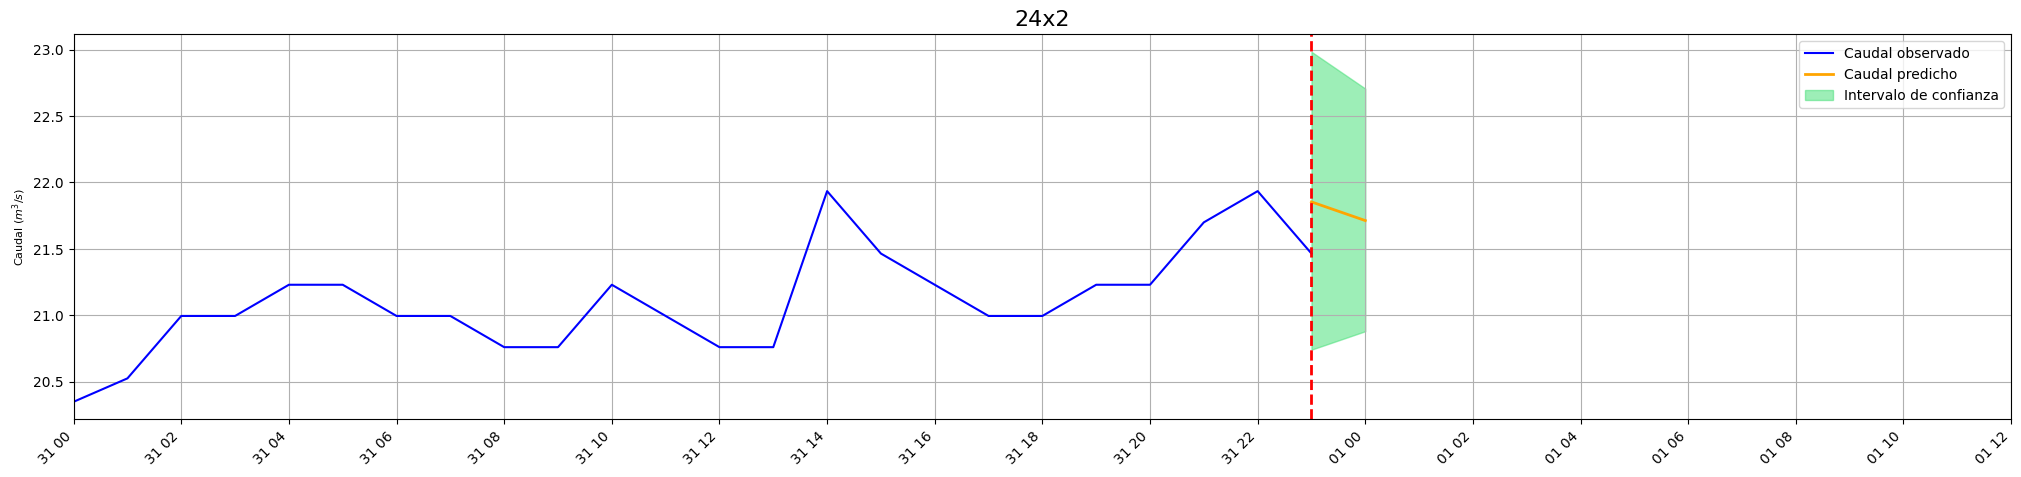

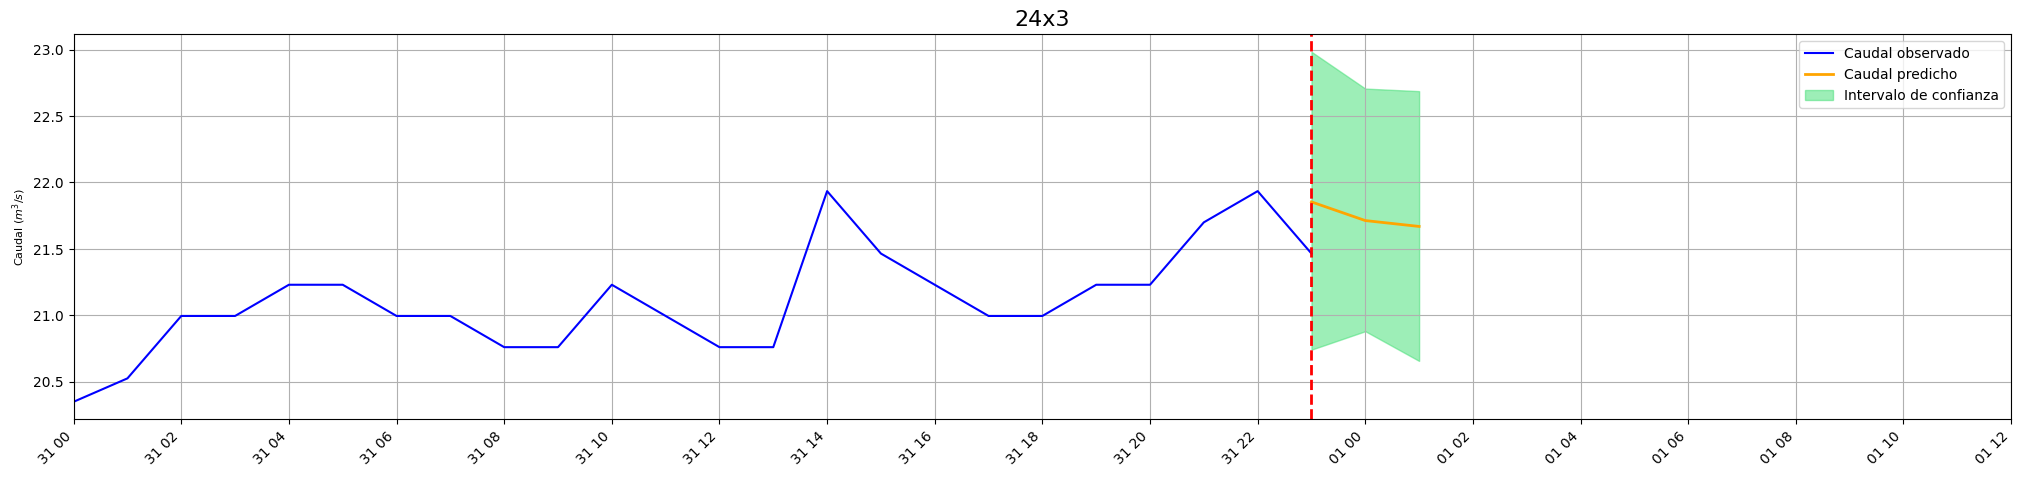

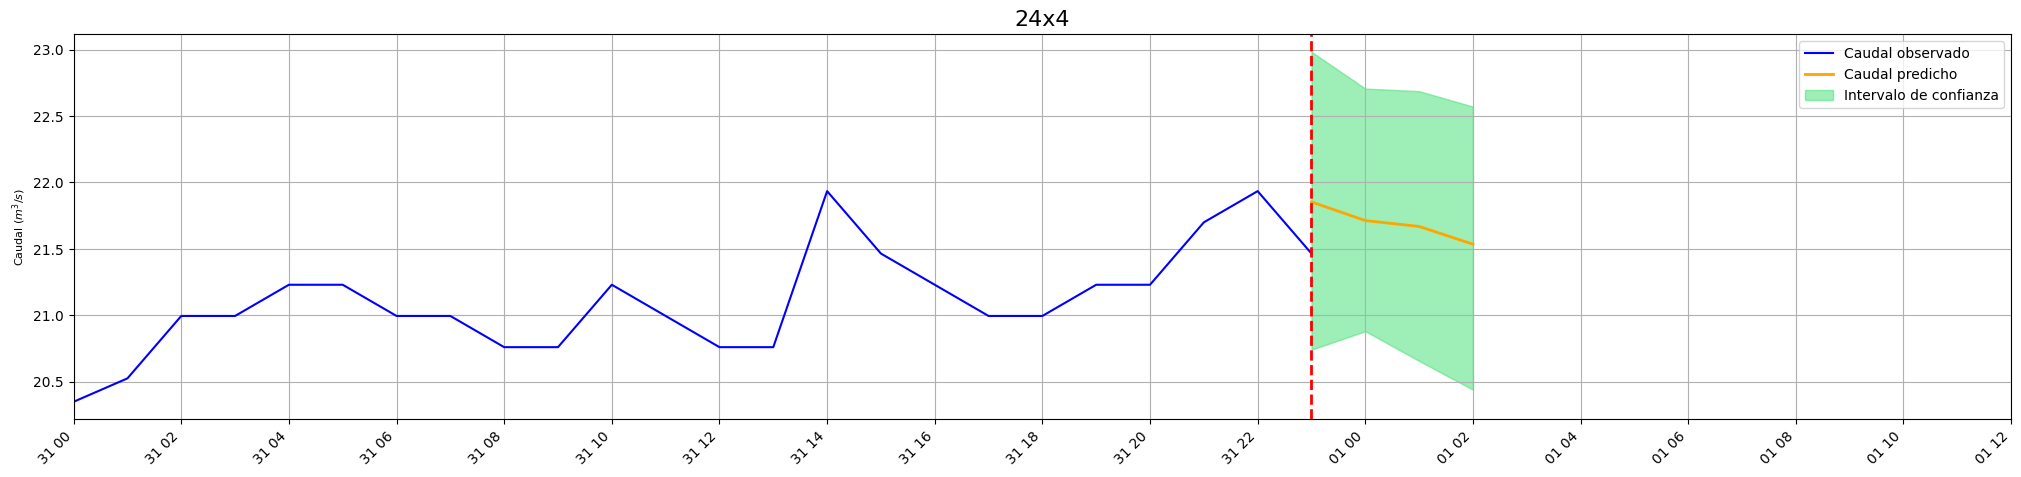

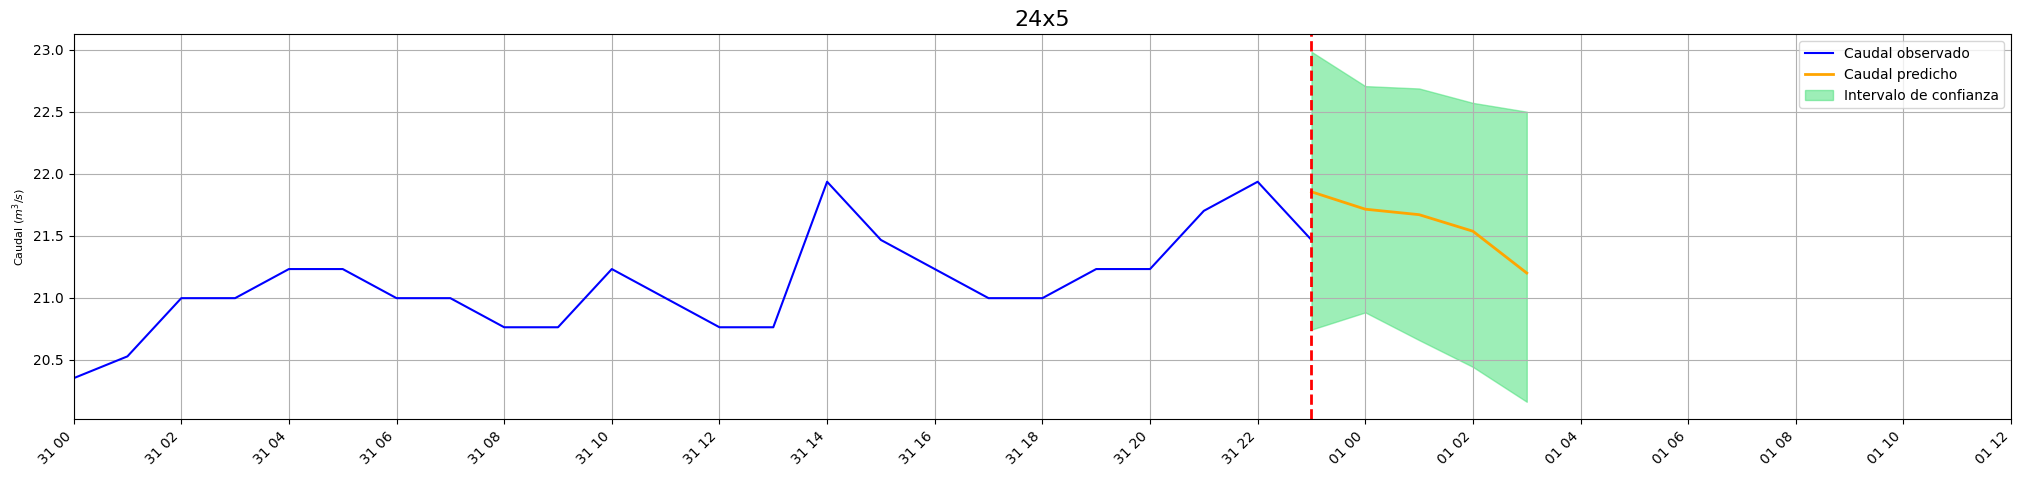

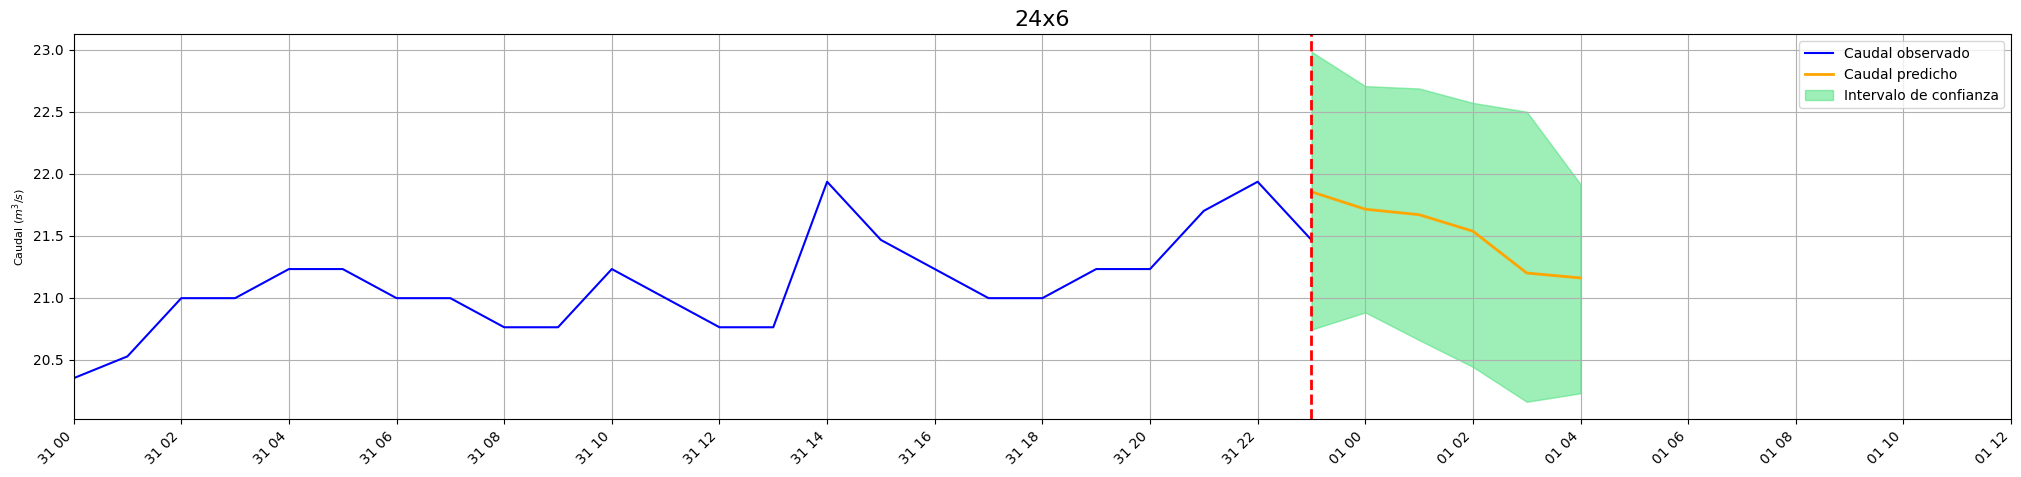

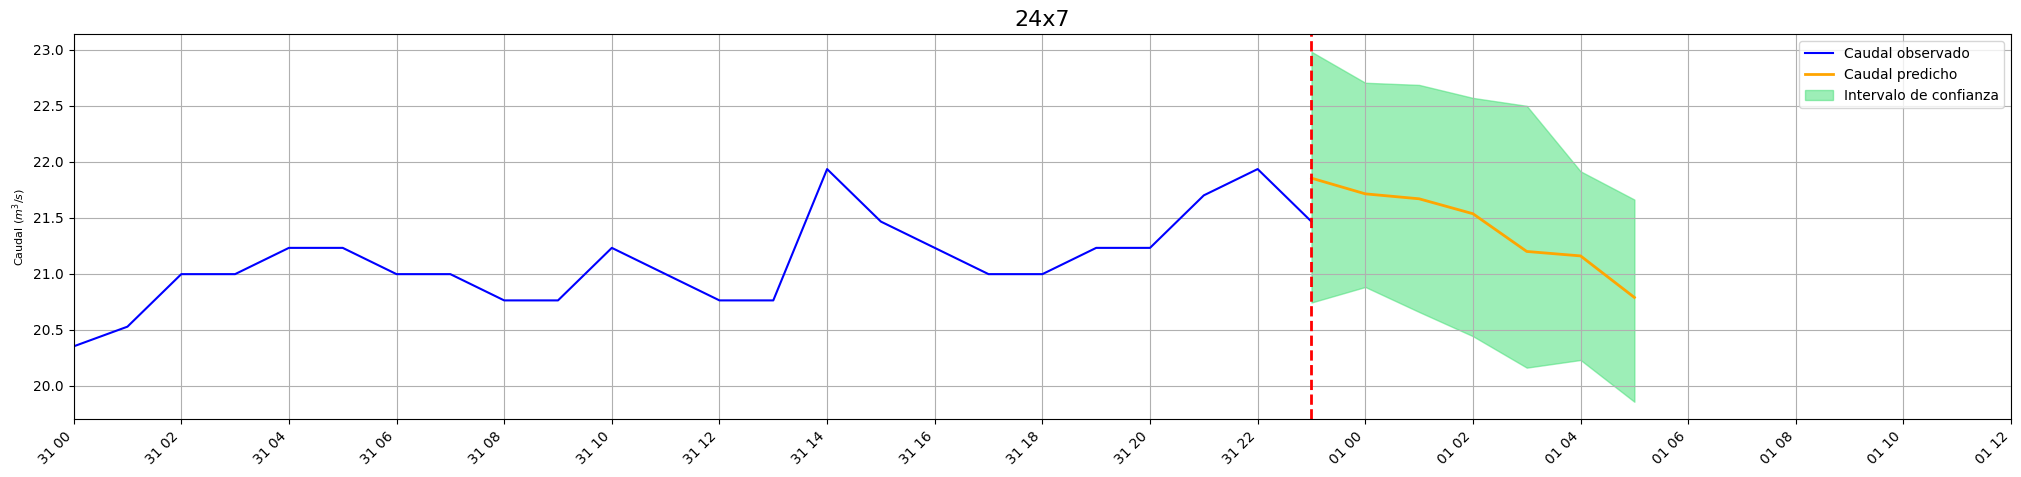

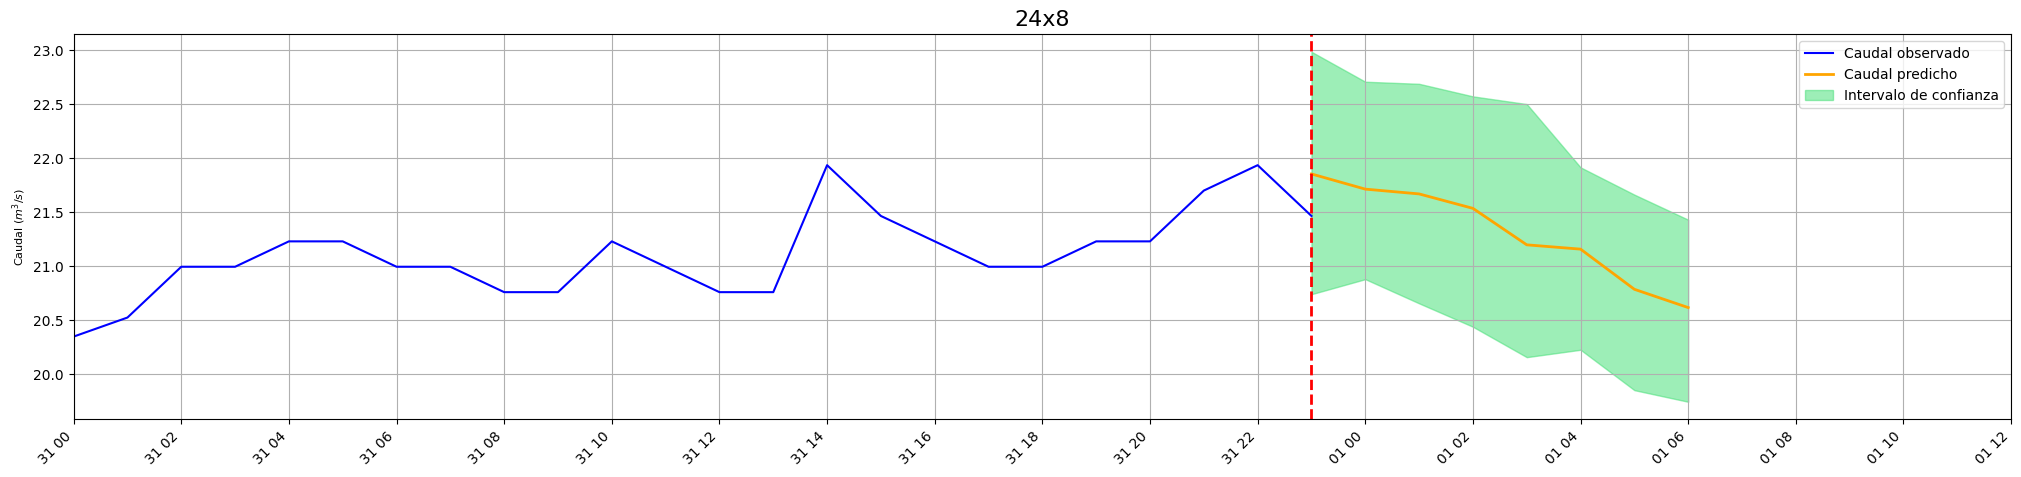

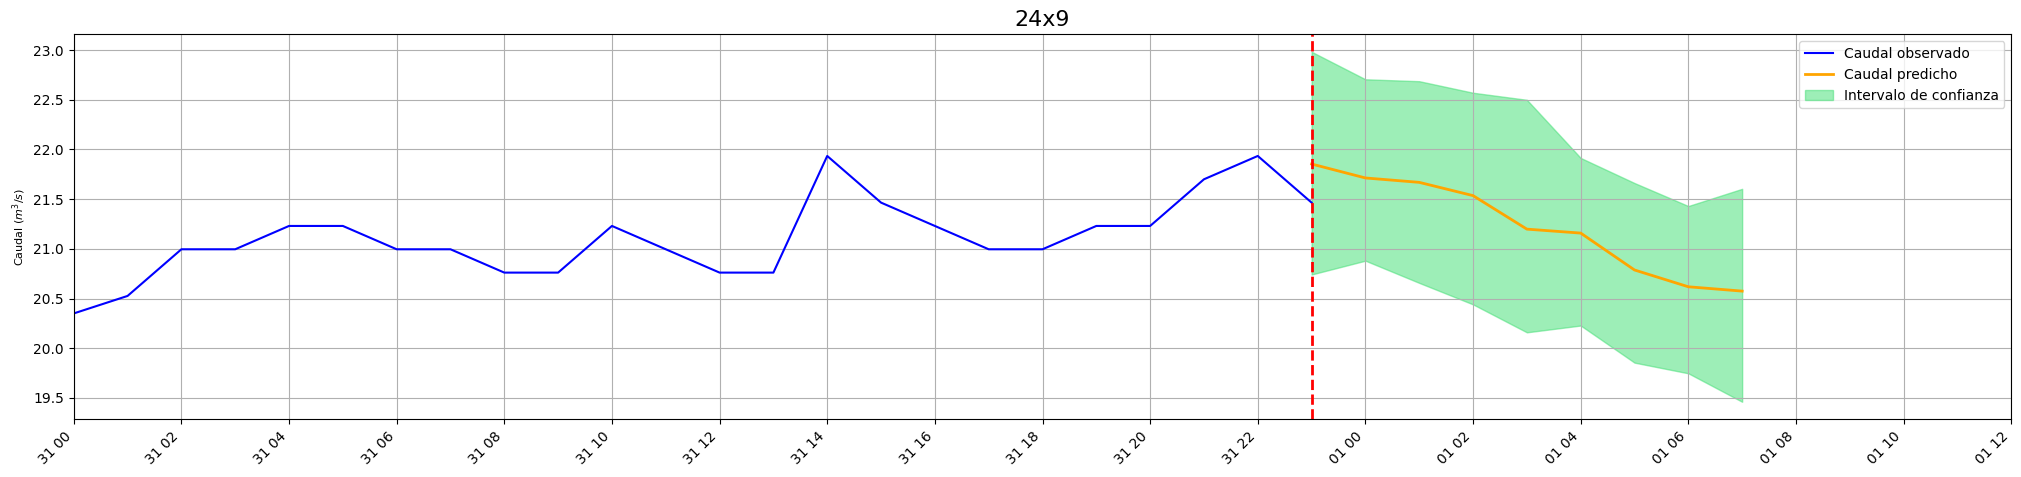

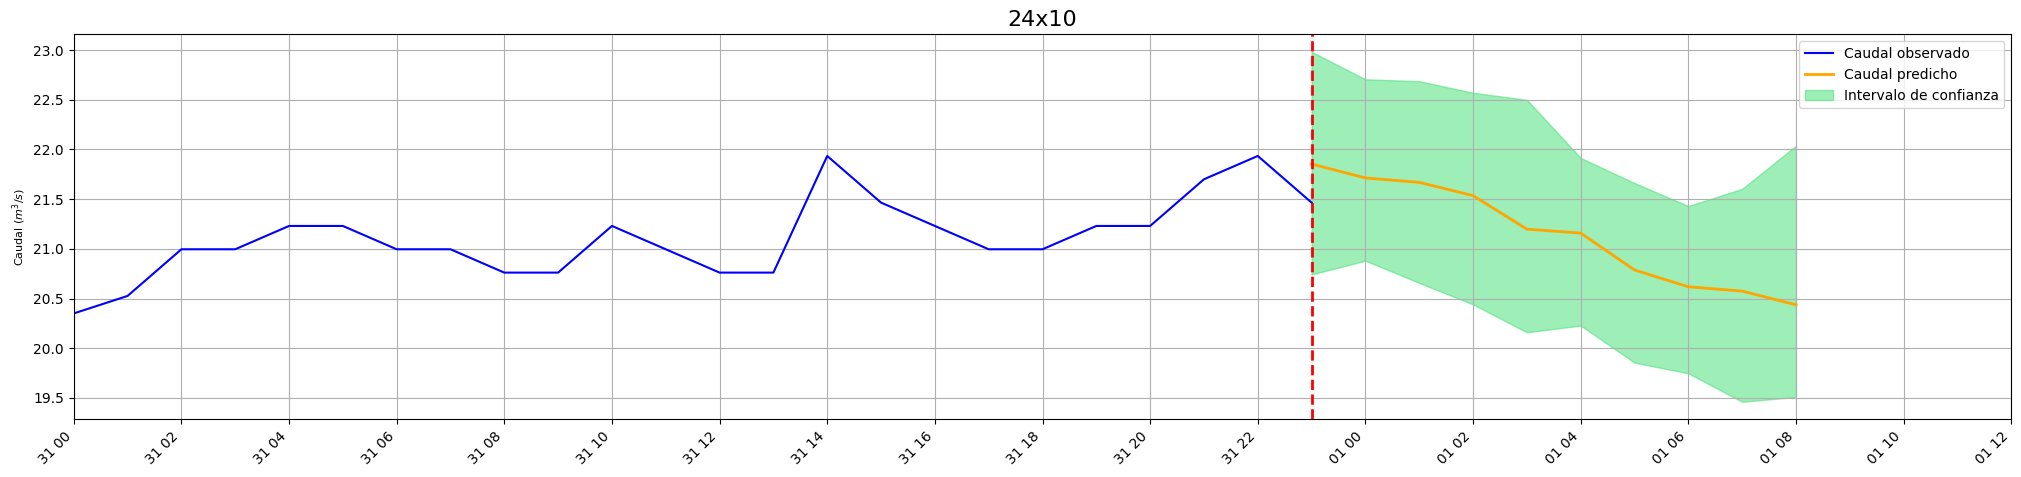

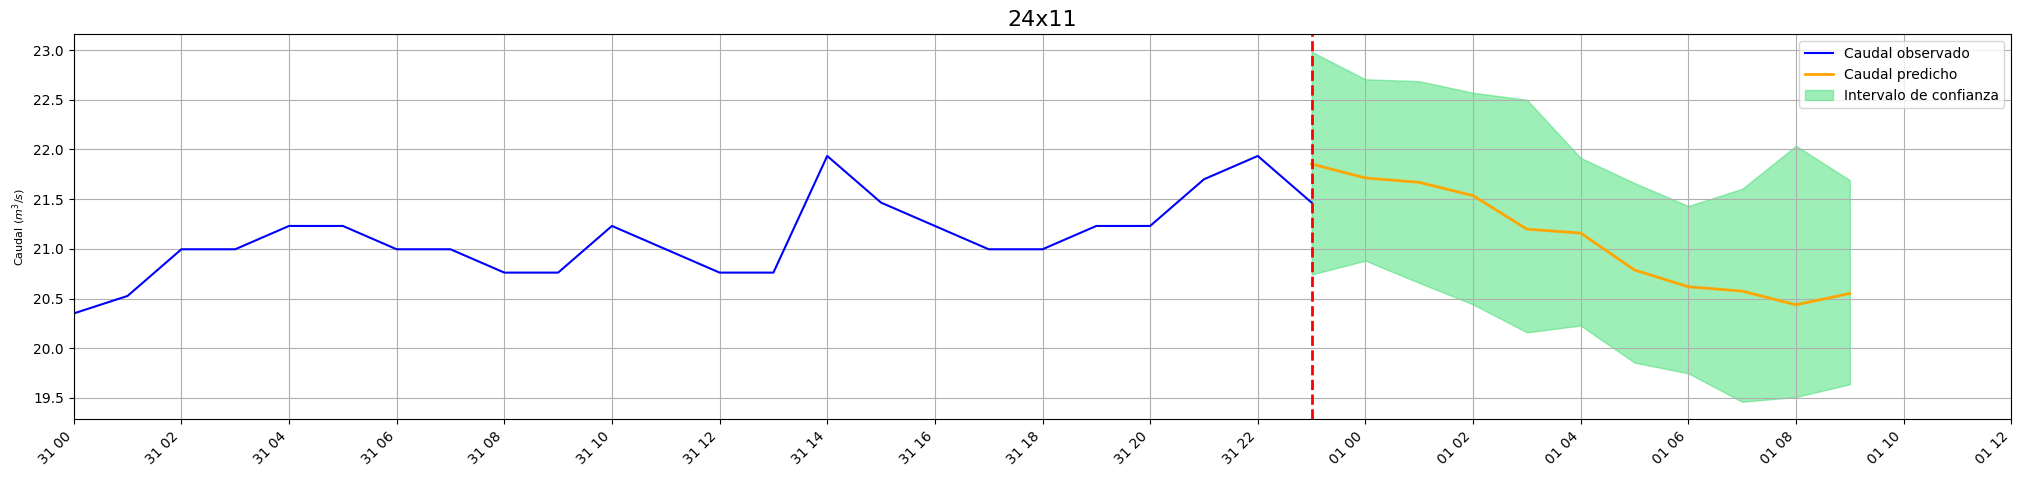

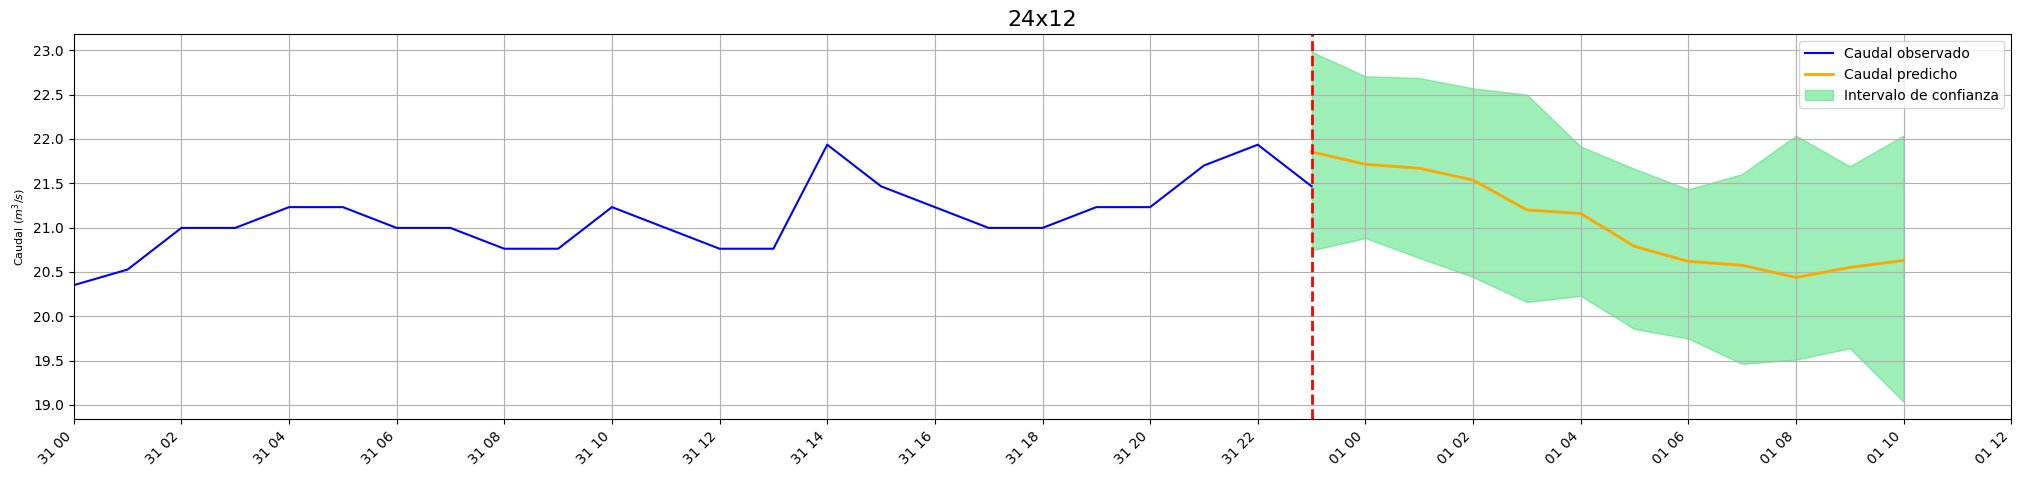

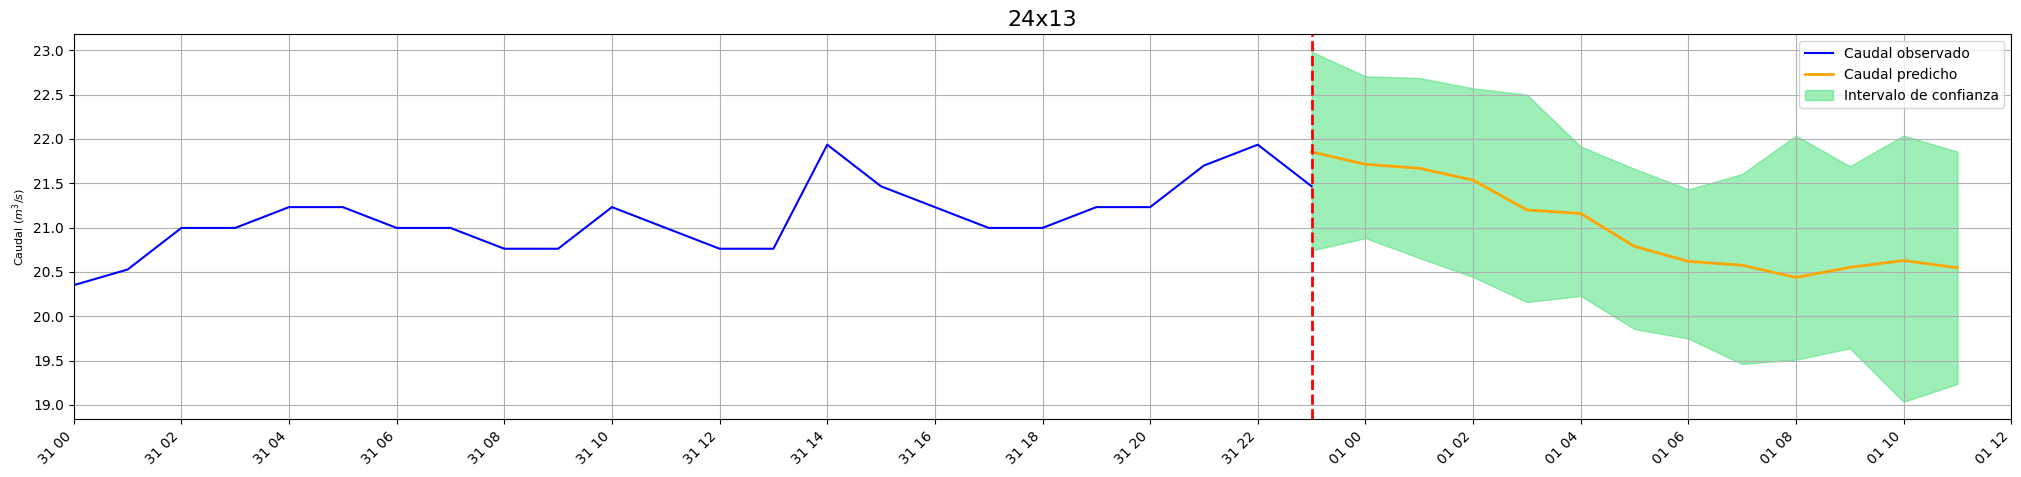

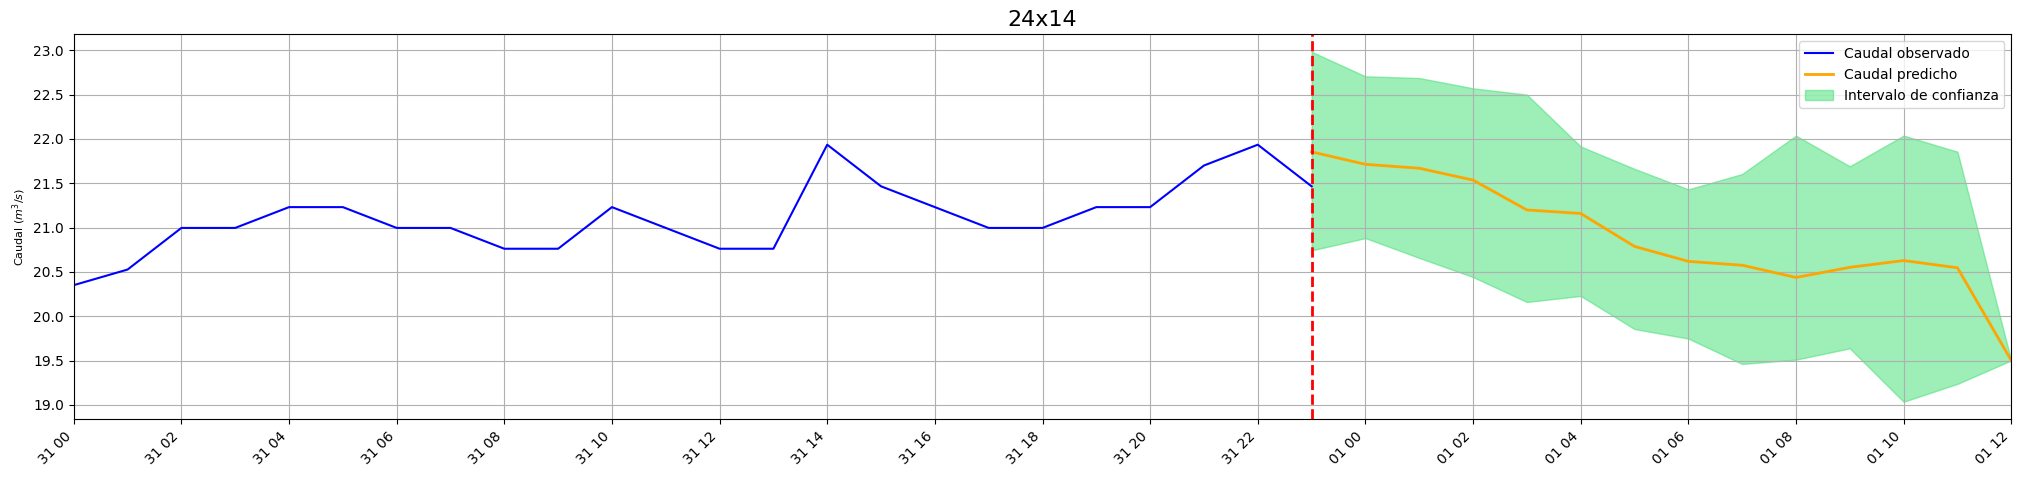

In [ ]:
# Graficar conos de incertidumbre
# lista_valores_x, lista_valores_y = graficar_conos(caudal_in, caudal_obs, caudal_pred, LAG, out_lengths)
D = graficar_conoss(caudal_in, caudal_obs, caudal_pred, LAG, out_lengths)

In [ ]:
D.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

In [ ]:
len(D[0])

5

In [ ]:
def crear_in_out(df, in_length, out_length):
    """
    Prepares input and output data for modeling, based on specific input and output lengths.
    :param df: DataFrame from which data will be extracted.
    :param in_length: Number of time steps to include in each input sample.
    :param out_length: Number of time steps to predict.
    :return: NumPy arrays for model inputs and outputs, along with their respective timestamps.
    """
    x, y, xtime, ytime = [], [], [], []
    data = df.values
    times = df.index
    nfils, ncols = data.shape

    for i in range(nfils - in_length - out_length):
        x.append(data[i:i+in_length, 0:ncols])
        y.append(data[i+in_length:i+in_length+out_length, -1].reshape(out_length, 1))
        xtime.append(times[i:i+in_length])
        ytime.append(times[i+in_length:i+in_length+out_length])

    return np.array(x), np.array(y), xtime, ytime

def train_val_test_split(df, tr_size=0.8, vl_size=0.1, ts_size=0.1):
    """
    Splits a DataFrame into training, validation, and test sets.
    :param df: DataFrame to be split.
    :param tr_size: Proportion of the training set.
    :param vl_size: Proportion of the validation set.
    :param ts_size: Proportion of the test set.
    :return: Three DataFrames corresponding to the training, validation, and test sets.
    """
    N = df.shape[0]
    Ntrain = int(tr_size * N)
    Nval = int(vl_size * N)
    Ntst = N - Ntrain - Nval

    df_train = df[0:Ntrain]
    df_val = df[Ntrain:Ntrain+Nval]
    df_test = df[Ntrain+Nval:]

    return df_train, df_val, df_test

def generar_particiones(dfs):
    """
    Generates training, validation, and test partitions for a list of DataFrames.
    :param dfs: List of DataFrames to partition.
    :return: Three lists of DataFrames corresponding to the training, validation, and test sets.
    """
    train, val, test = [], [], []

    cont = 0
    for df in dfs:
        # print(cont, end="|")
        df_train, df_val, df_test = train_val_test_split(df)
        train.append(df_train)
        val.append(df_val)
        test.append(df_test)
        cont+=1

    return train, val, test

def preparar_conjuntos(train, val, test, in_length, out_lengths):
    """
    Prepares datasets for training, validation, and testing for different output lengths.
    :param train: List of training DataFrames.
    :param val: List of validation DataFrames.
    :param test: List of test DataFrames.
    :param in_length: Number of time steps to include in each input sample.
    :param out_lengths: List of different output lengths for preparing the datasets.
    :return: Dictionary containing the prepared datasets for each output length.
    """
    datasets = {}
    for out_length in out_lengths:
        datasets[str(out_length)] = {
            'train': {'x': None, 'y': None, 'x_time': None, 'y_time': None},
            'val': {'x': None, 'y': None, 'x_time': None, 'y_time': None},
            'test': {'x': None, 'y': None, 'x_time': None, 'y_time': None}
        }

        for subset, datasets_subset in zip([train, val, test], ['train', 'val', 'test']):
            x_subset, y_subset, xtime_subset, ytime_subset = [], [], [], []
            for df in subset:
                x, y, xtime, ytime = crear_in_out(df, in_length, out_length)
                x_subset.append(x)
                y_subset.append(y)
                xtime_subset.extend(xtime)
                ytime_subset.extend(ytime)

            x_subset = np.concatenate(x_subset, axis=0)
            y_subset = np.concatenate(y_subset, axis=0)

            datasets[str(out_length)][datasets_subset]['x'] = x_subset
            datasets[str(out_length)][datasets_subset]['y'] = y_subset
            datasets[str(out_length)][datasets_subset]['x_time'] = xtime_subset
            datasets[str(out_length)][datasets_subset]['y_time'] = ytime_subset

    return datasets

def escalar_datos(tr_vl_ts, out_lengths, loaded_scaler):
    """
    Scales the data from the training, validation, and test sets.
    :param tr_vl_ts: Dictionary containing the original datasets.
    :param out_lengths: List of output lengths for which the data has been prepared.
    :return: A dictionary with scaled data and the scaler object used.
    """
    tr_vl_ts_s = {}
    x_tr = tr_vl_ts['1']['train']['x']
    batch, in_length, nfeats = x_tr.shape

    for out_length in out_lengths:
        tr_vl_ts_s[str(out_length)] = {
            'train': {'x': None, 'y': None, 'x_time': None, 'y_time': None},
            'val': {'x': None, 'y': None, 'x_time': None, 'y_time': None},
            'test': {'x': None, 'y': None, 'x_time': None, 'y_time': None}
        }

        for subset_key in ['train', 'val', 'test']:
            x = tr_vl_ts[str(out_length)][subset_key]['x']
            y = tr_vl_ts[str(out_length)][subset_key]['y']

            x_s = loaded_scaler.transform(x.reshape(x.shape[0] * x.shape[1], x.shape[2]))
            mx, mn = loaded_scaler.data_max_[-1], loaded_scaler.data_min_[-1]
            y_s = (y.flatten() - mn) / (mx - mn)

            tr_vl_ts_s[str(out_length)][subset_key]['x'] = x_s.reshape(x.shape)
            tr_vl_ts_s[str(out_length)][subset_key]['y'] = y_s.reshape(y.shape)

    return tr_vl_ts_s

def predecir_tr_vl_ts(tr_vl_ts_s, modelos, scaler, in_length, out_lengths):
    """
    Performs predictions on the training, validation, and test sets using pre-trained models.
    :param tr_vl_ts_s: Scaled training, validation, and test sets.
    :param modelos: Dictionary of pre-trained models.
    :param scaler: Scaler object used for data scaling.
    :param in_length: Input length of the models.
    :param out_lengths: List of output lengths for which predictions will be made.
    :return: Dictionary with the predictions made on each dataset.
    """
    mn = scaler.data_min_[-1]
    mx = scaler.data_max_[-1]

    preds_tr_vl_ts = {str(out_length): {'train': None, 'val': None, 'test': None} for out_length in out_lengths}
    for out_length in out_lengths:
        key = f'{in_length}x{out_length}'
        x_tr = tr_vl_ts_s[str(out_length)]['train']['x']
        x_vl = tr_vl_ts_s[str(out_length)]['val']['x']
        x_ts = tr_vl_ts_s[str(out_length)]['test']['x']

        modelo = modelos[key]
        y_tr_pred = (mx - mn) * modelo.predict(x_tr, verbose=0) + mn
        y_vl_pred = (mx - mn) * modelo.predict(x_vl, verbose=0) + mn
        y_ts_pred = (mx - mn) * modelo.predict(x_ts, verbose=0) + mn

        preds_tr_vl_ts[str(out_length)]['train'] = y_tr_pred
        preds_tr_vl_ts[str(out_length)]['val'] = y_vl_pred
        preds_tr_vl_ts[str(out_length)]['test'] = y_ts_pred

    return preds_tr_vl_ts

In [ ]:
### OPCIONAL

# Preparar conjuntos de datos
train, val, test = generar_particiones(dataframes[8:9])
tr_vl_ts = preparar_conjuntos(train, val, test, LAG, out_lengths)

In [ ]:
# Escalar los datos y obtener el scaler
tr_vl_ts_s = escalar_datos(tr_vl_ts, out_lengths, scaler)

In [ ]:
# Realizar predicciones sobre los conjuntos de entrenamiento, validación y prueba
preds_tr_vl_ts = predecir_tr_vl_ts(tr_vl_ts_s, modelos, scaler, LAG, out_lengths)

In [ ]:
# Calcular índices de desempeño
nse_train, nse_val, nse_test = calcular_indices_desempeno(preds_tr_vl_ts, tr_vl_ts_s, scaler, LAG, out_lengths)

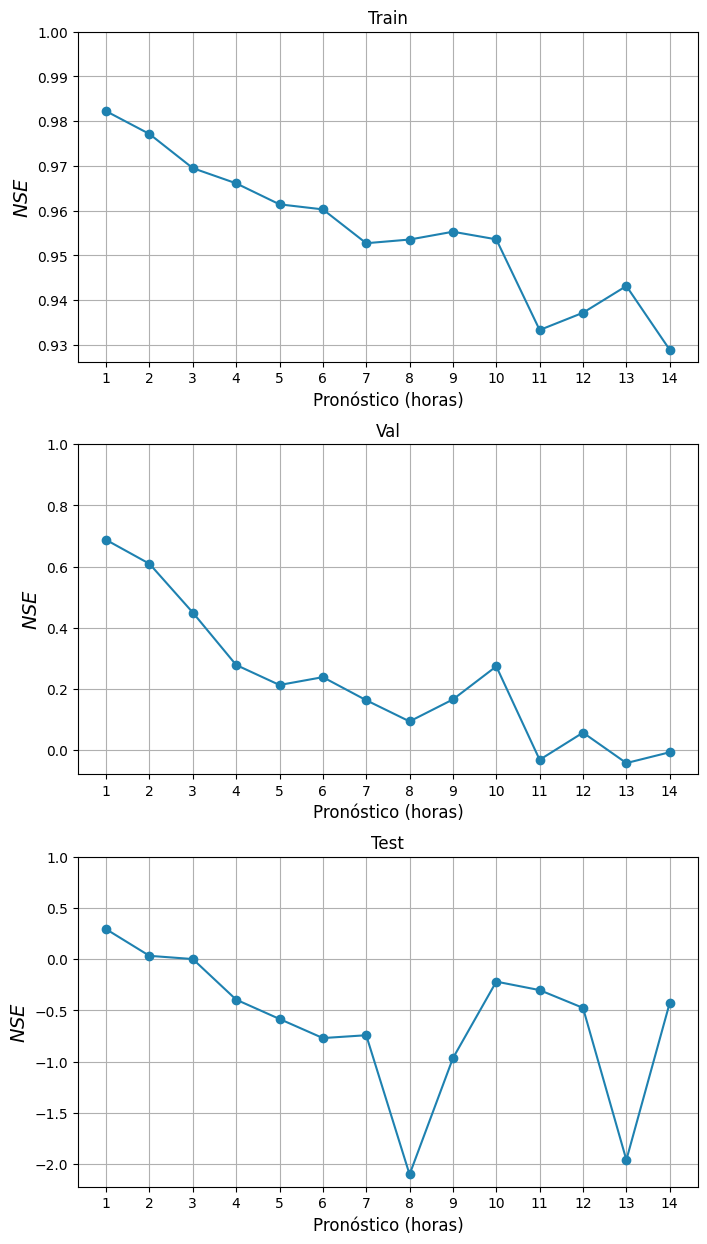

In [ ]:
# Graficar índices NSE
graficar_indice_nse(nse_train, nse_val, nse_test, out_lengths)